# **New Zealand flood study - exploratory anallysis**

**Data sources:**

- Gridded elevation data: https://download.gebco.net/
- NZ administrative shapefiles: https://datafinder.stats.govt.nz (Regional Council 2023 Clipped (generalised), New Zealand)
- Hydro catchments: https://www.hydrosheds.org/products/hydrosheds
- Station data from https://cliflo.niwa.co.nz/

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

In [3]:
# # extract necessary data from MSWEP daily files
# for y in range(1979, 2021):
#     ds = xr.open_mfdataset("/home/clair/Data/mswep_past/"+str(y)+"*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179))
#     ds.to_netcdf("data/mswep-daily_"+str(y)+".nc")
    
# for y in range(2021, 2024):
#     ds = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179))
#     ds.to_netcdf("data/mswep-daily_"+str(y)+".nc")

## **Event map (MSWEP)**

In [2]:
pr = xr.open_mfdataset("/home/clair/Data/mswep_3hr/*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179)).precipitation.load()

# adjust for local time zone
pr_nz = pr.assign_coords(time = [t + np.timedelta64(13, "h") for t in pr.time.values])

# extract event itself
pr_1314 = pr_nz.sel(time = slice("2023-02-13", None)).sum("time").assign_attrs(units = "mm").sel(lat = slice(-34, -42), lon = slice(172, 179))
pr_utc = pr.resample(time = "D").sum().rolling(time = 2, center = False).sum().sel(time = "2023-02-13").assign_attrs(units = "mm")

### **3-hourly maps**

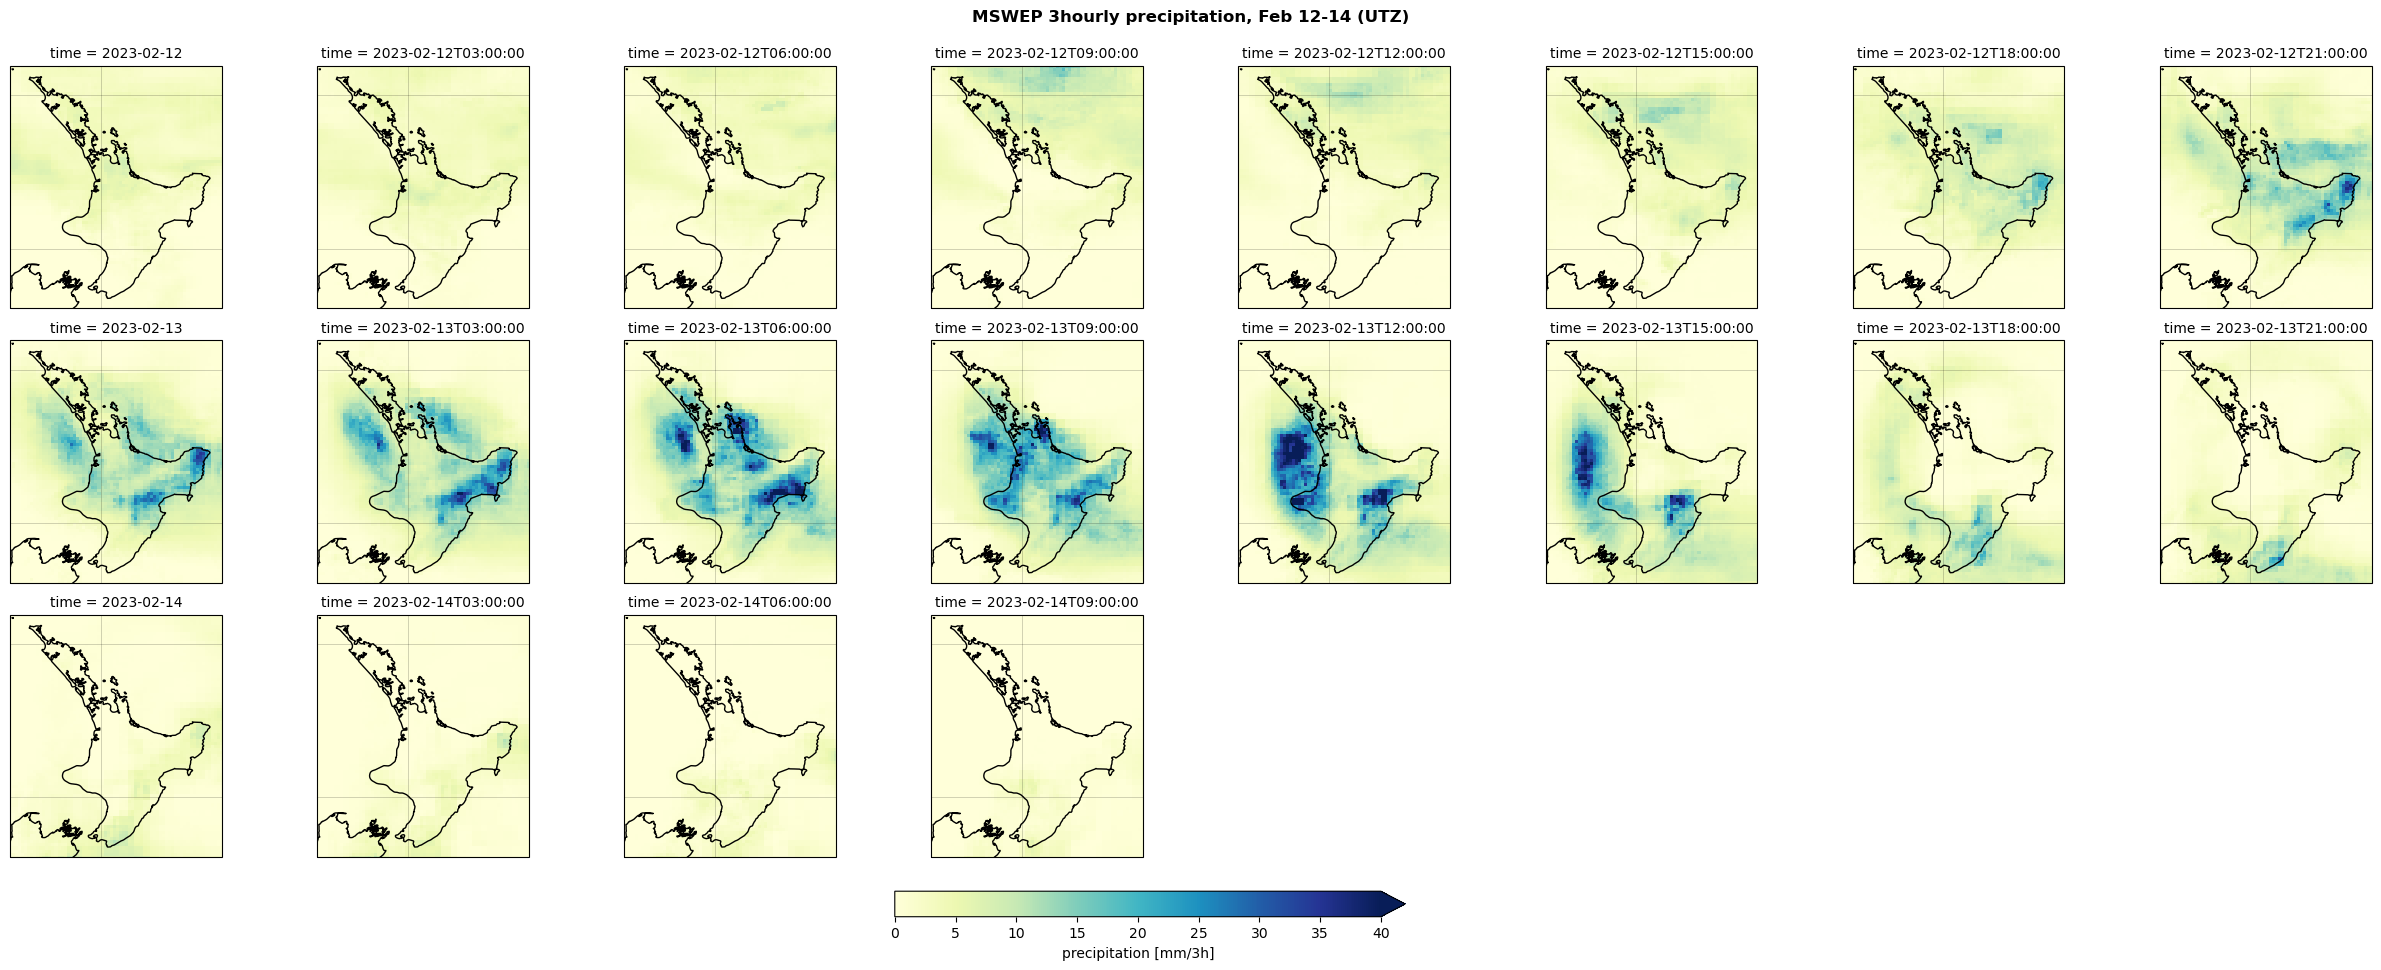

In [3]:
# UTC
pr.sel(time = slice("2023-02-12", None)).plot(col = "time", col_wrap = 8, cmap = "YlGnBu", vmax = 40, 
                                              subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                             "extent" : (pr.lon.min().values, pr.lon.max().values, pr.lat.min().values, pr.lat.max().values)},
                                              cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04})
for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    
plt.suptitle("MSWEP 3hourly precipitation, Feb 12-14 (UTZ)", y = 1.025, fontweight = "bold")

plt.savefig("mswep-3hourly-utc.png")

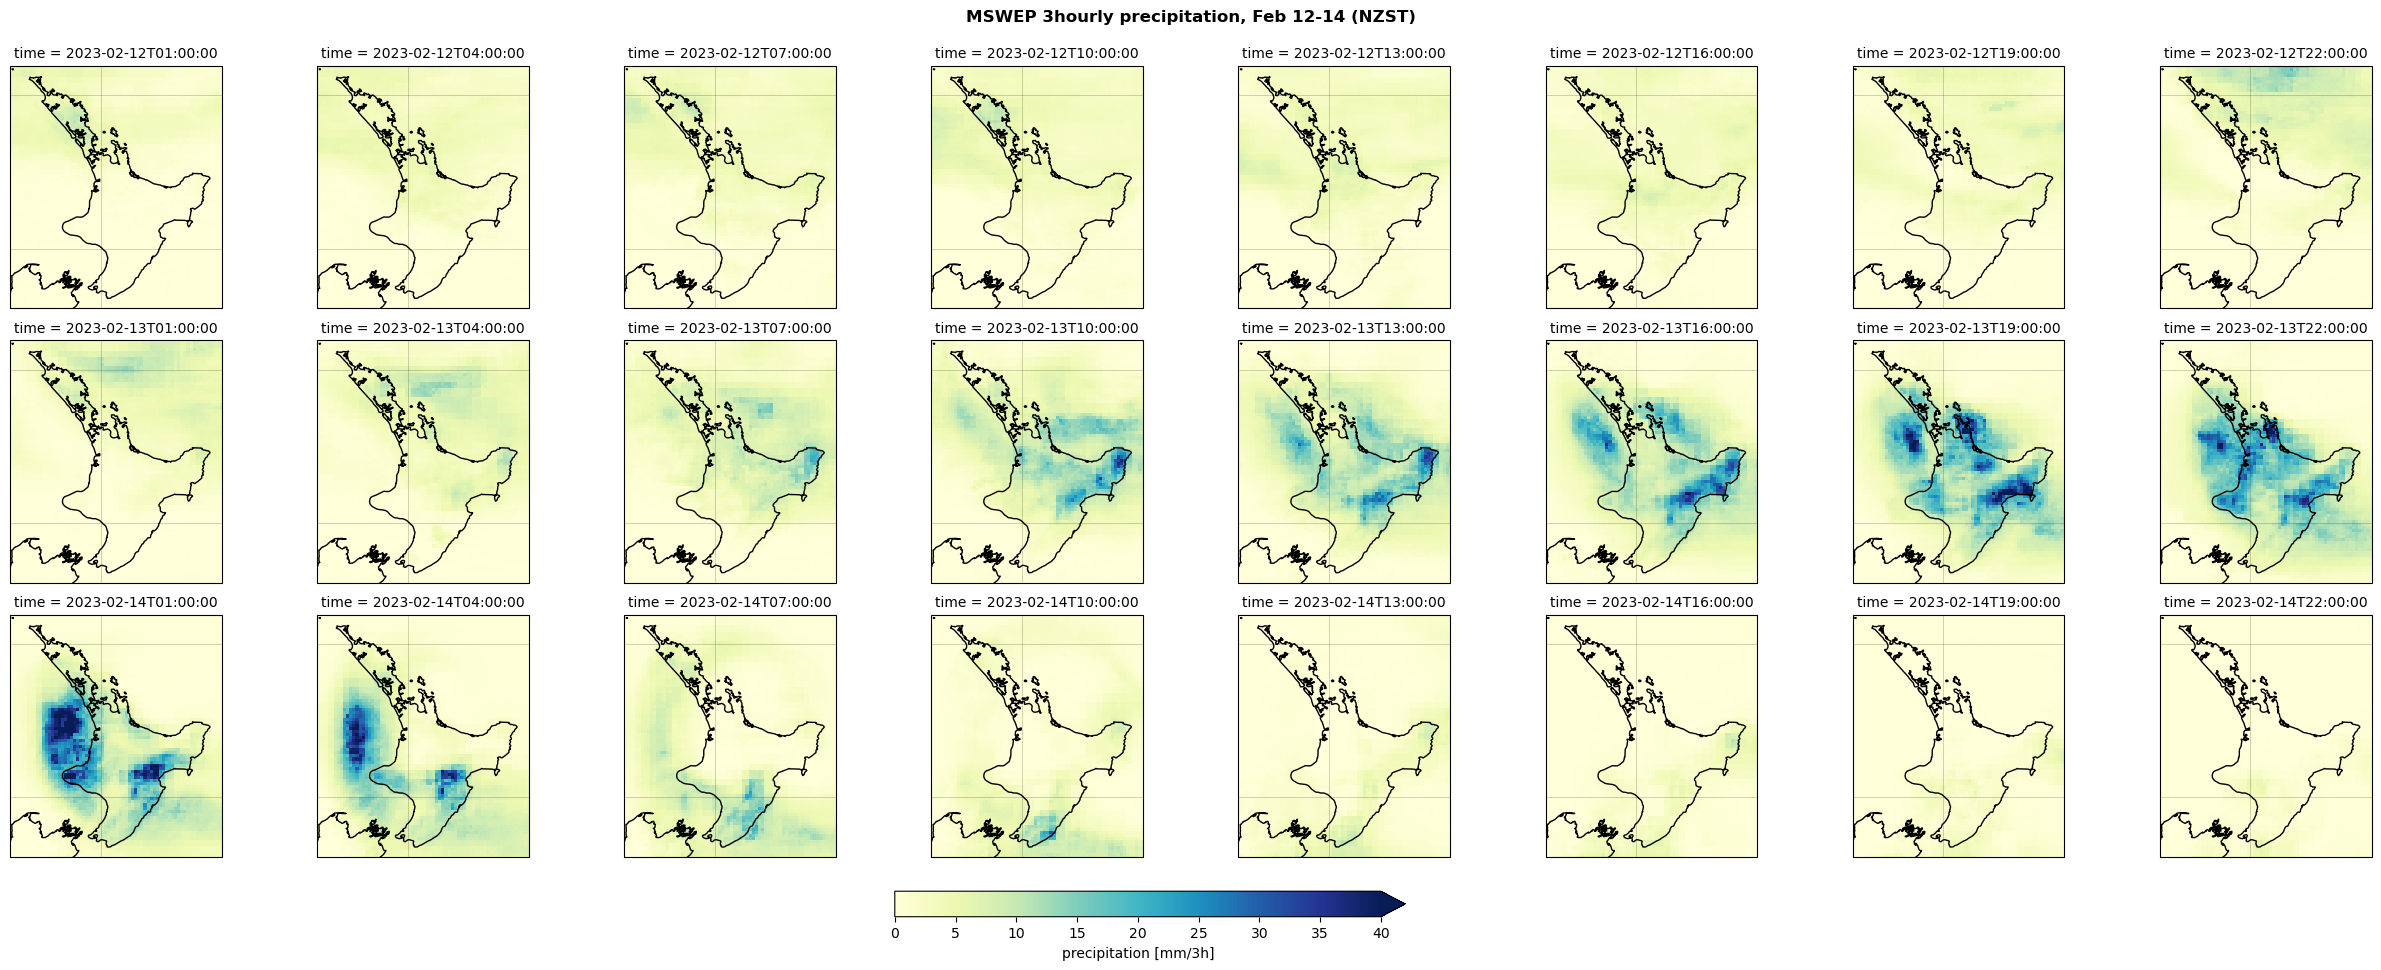

In [4]:
pr_nz.sel(time = slice("2023-02-12", None)).plot(col = "time", col_wrap = 8, cmap = "YlGnBu", vmax = 40, 
                                              subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                             "extent" : (pr.lon.min().values, pr.lon.max().values, pr.lat.min().values, pr.lat.max().values)},
                                              cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04})
for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    
plt.suptitle("MSWEP 3hourly precipitation, Feb 12-14 (NZST)", y = 1.025, fontweight = "bold")

plt.savefig("mswep-3hourly-nzst.png")

### **North Island 2-day precip**

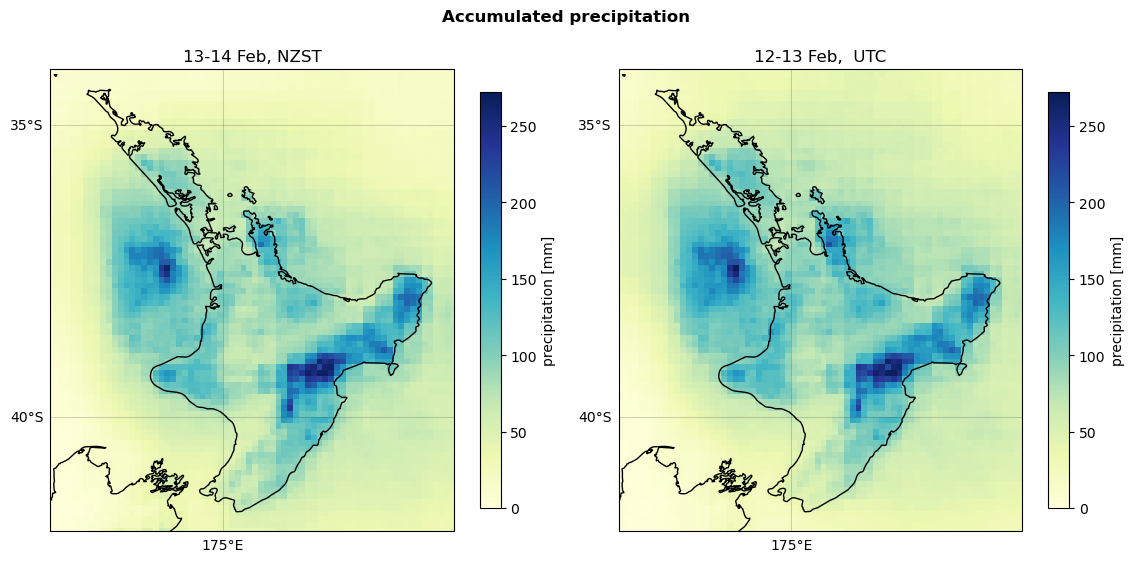

In [5]:
# 2-day rolling precip in UTC captures precip from 1pm on 12th-1pm on 14th

fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.1)

pr_1314.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, vmax = 272, cbar_kwargs = {"shrink" : 0.9}); axs[0].set_title("13-14 Feb, NZST")
pr_utc.plot(ax = axs[1], cmap = "YlGnBu", vmin = 0, vmax = 272, cbar_kwargs = {"shrink" : 0.9}); axs[1].set_title("12-13 Feb,  UTC")

plt.suptitle("Accumulated precipitation", fontweight = "bold")
for ax in axs:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, draw_labels = ["bottom", "left"], color='black', alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    
plt.savefig("mswep-northisland-pr2day.png")

---
## **Define study region**

In [260]:
pr = xr.open_mfdataset("/home/clair/Data/mswep_3hr/*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179)).precipitation.load()

# adjust for local time zone
pr_nz = pr.assign_coords(time = [t + np.timedelta64(13, "h") for t in pr.time.values])

# extract event itself
pr_1314 = pr_nz.sel(time = slice("2023-02-13", None)).sum("time").assign_attrs(units = "mm").sel(lat = slice(-34, -42), lon = slice(172, 179))
pr_utc = pr.resample(time = "D").sum().rolling(time = 2, center = False).sum().sel(time = "2023-02-13").assign_attrs(units = "mm")

In [269]:
regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())
# hwy1 = gpd.read_file("sf/nz_roads/").to_crs(cartopy.crs.PlateCarree())
# hwy1 = hwy1.loc[hwy1.name == "State Highway 1"]

elev = xr.open_dataset("data/gebco_elevation.nc").elevation

### **Hawkes Bay & Gisborne/Tarawhiti**

In [270]:
# merge selected region
sf = regions.loc[[4,5]].dissolve().explode(index_parts = True)

# get the single largest polygon as boundary
sf = sf[sf.geometry.area == sf.geometry.area.max()]
sf.to_file("sf_hawkes-gisborne")

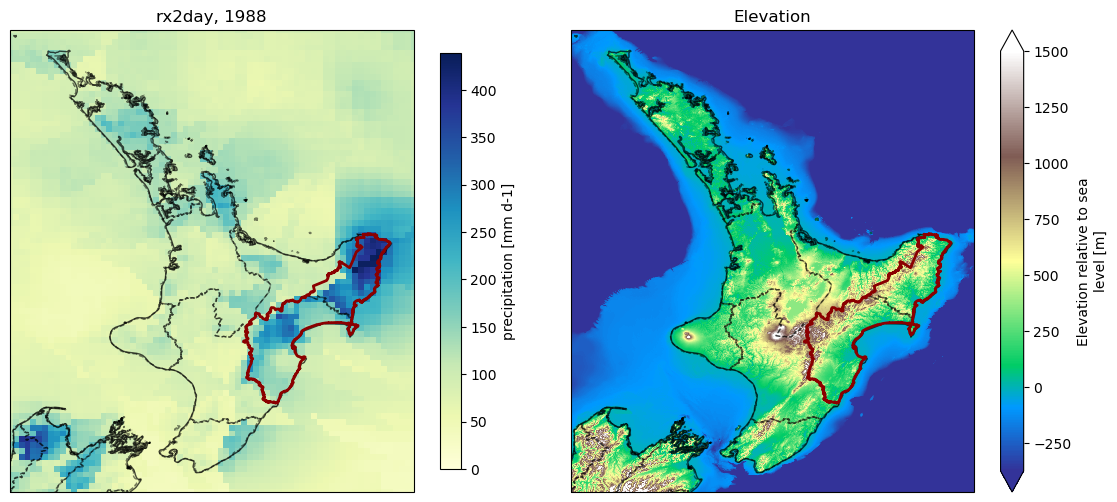

In [278]:
pr_2day = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation.rolling(time = 2, center = False).sum()
bowler = pr_2day.groupby("time.year")[1988].max("time")

cbar_kwargs = {"shrink" : 0.9}
fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.07)

bowler.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, cbar_kwargs = cbar_kwargs)
axs[0].set_title("rx2day, 1988")

elev.plot(ax = axs[1], cmap = "terrain", vmin = -375, vmax = 1500)
axs[1].set_title("Elevation")

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.5)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred", label = "Suggested region")
    
    plt.savefig("candidate-region-1.png")

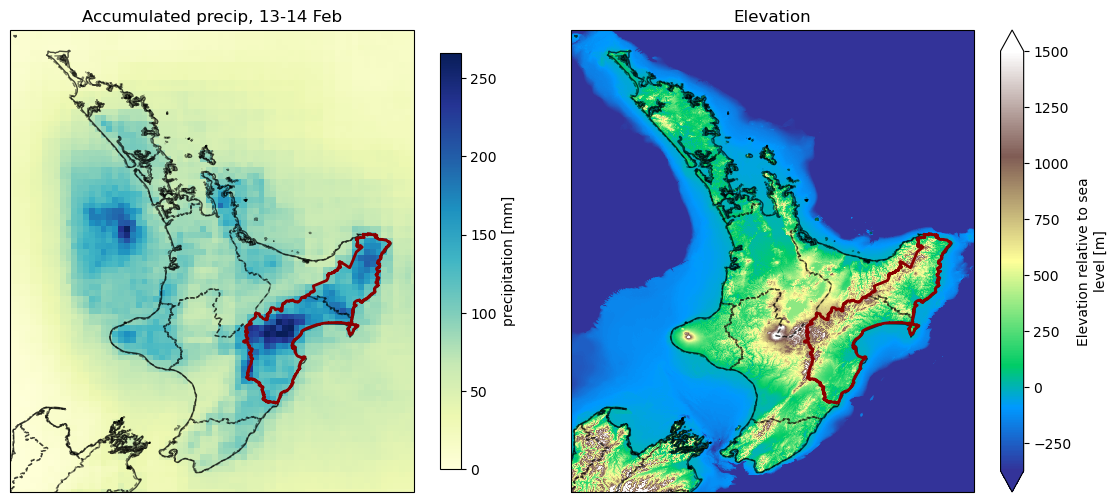

In [13]:
hg = gpd.read_file("sf_hawkes-gisborne")

cbar_kwargs = {"shrink" : 0.9}
fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.07)

pr_1314.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, cbar_kwargs = cbar_kwargs)
axs[0].set_title("Accumulated precip, 13-14 Feb")

elev.plot(ax = axs[1], cmap = "terrain", vmin = -375, vmax = 1500)
axs[1].set_title("Elevation")

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.5)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred", label = "Suggested region")
        
plt.savefig("candidate-region-1.png")

### **Hawkes Bay & Gisborne/Tarawhiti, Bay of Plenty**

In [ ]:
# merge selected region
sf2 = regions.loc[[3,4,5]].dissolve().explode(index_parts = True)

# get the single largest polygon as boundary
sf2 = sf2[sf2.geometry.area == sf2.geometry.area.max()]
sf2.to_file("sf_hawkes-gisborne-plenty")

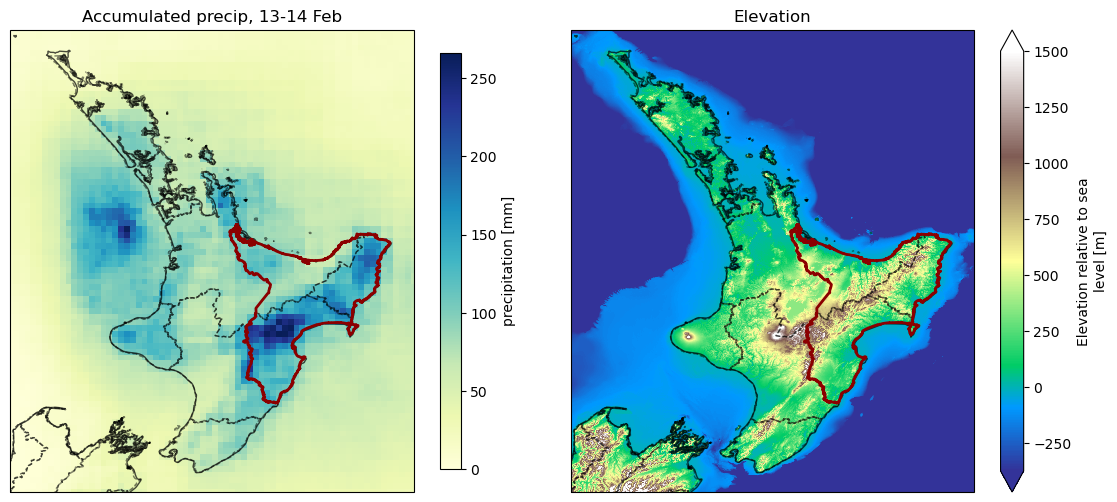

In [14]:
hgp = gpd.read_file("sf_hawkes-gisborne-plenty")

cbar_kwargs = {"shrink" : 0.9}
fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.07)

pr_1314.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, cbar_kwargs = cbar_kwargs)
axs[0].set_title("Accumulated precip, 13-14 Feb")

elev.plot(ax = axs[1], cmap = "terrain", vmin = -375, vmax = 1500)
axs[1].set_title("Elevation")

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.5)
    hgp.boundary.plot(ax = ax, lw = 2, color = "darkred", label = "Suggested region")
    
plt.savefig("candidate-region-2.png")

### **NE coast of North Island**

Extend the region to include the whole coastal region, as suggested by Luke

In [38]:
nz = gpd.read_file("sf/hybas_02/").loc[[6],:]

basin05 = gpd.read_file("sf/hybas_05/").clip(nz).to_crs(cartopy.crs.PlateCarree())
basin05 = basin05[basin05.geometry.centroid.y == basin05.geometry.centroid.y.max()]
basin05 = basin05.dissolve().explode(index_parts = True)
basin05 = basin05[basin05.geometry.area == basin05.geometry.area.max()]
basin05.to_file("sf_ne-coast")

In [54]:
# merge selected region
sf2 = regions.loc[[1,2]].dissolve().explode(index_parts = True)

# get the single largest polygon as boundary
sf2 = sf2[sf2.geometry.area == sf2.geometry.area.max()]
sf2.to_file("sf_northland-auckland")

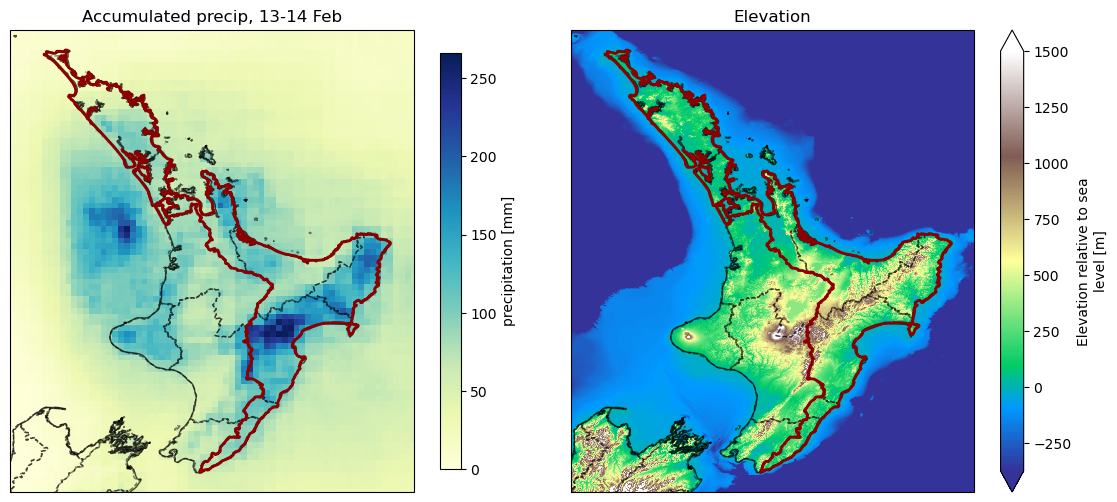

In [16]:
ne = gpd.read_file("sf_ne-coast")

cbar_kwargs = {"shrink" : 0.9}
fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.07)

pr_1314.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, cbar_kwargs = cbar_kwargs)
axs[0].set_title("Accumulated precip, 13-14 Feb")

elev.plot(ax = axs[1], cmap = "terrain", vmin = -375, vmax = 1500)
axs[1].set_title("Elevation")

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.5)
    ne.boundary.plot(ax = ax, lw = 2, color = "darkred", label = "Suggested region")
        
plt.savefig("candidate-region-NEcoast.png")

### **3hourly precip in each proposed region**

In [22]:
hg = gpd.read_file("sf_hawkes-gisborne/")
hgp = gpd.read_file("sf_hawkes-gisborne-plenty/")
ne = gpd.read_file("sf_ne-coast")
na = gpd.read_file("sf_northland-auckland")

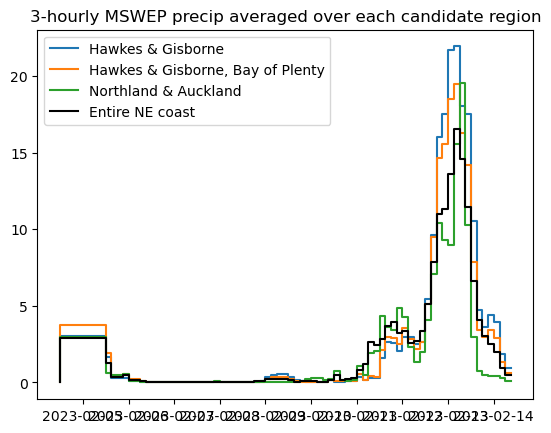

In [21]:
pr = xr.open_mfdataset("/home/clair/Data/mswep_3hr/*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179)).precipitation.load()

pr_hg, pr_hgp, pr_ne, pr_na = [pr.where(regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]) for sf in [hg, hgp, ne, na]]

plt.step(pr_hg.time, pr_hg, label = "Hawkes & Gisborne")
plt.step(pr_hgp.time, pr_hgp, label = "Hawkes & Gisborne, Bay of Plenty")
plt.step(pr_na.time, pr_na, label = "Northland & Auckland")
plt.step(pr_ne.time, pr_ne, label = "Entire NE coast", color = "k")

plt.title("3-hourly MSWEP precip averaged over each candidate region")
plt.legend()

---
## **MSWEP rx2day**

In [2]:
rx2day = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation.rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().rename("rx2day").assign_attrs(units = "mm")
rx2day = rx2day.assign_coords(time = rx2day.time.dt.year+1)
rx2day.to_netcdf("data/mswep_rx2day.nc")

# also useful to check trend without Cyclone Gabrielle
rx2day = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation.sel(time = slice(None, "2023-02-11")).rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().rename("rx2day").assign_attrs(units = "mm")
rx2day = rx2day.assign_coords(time = rx2day.time.dt.year+1)
rx2day.to_netcdf("data/mswep_rx2day_excluding-event.nc")

Text(0.5, 0.98, 'rx2day Jun22-Feb23 with & without Cyclone Gabrielle')

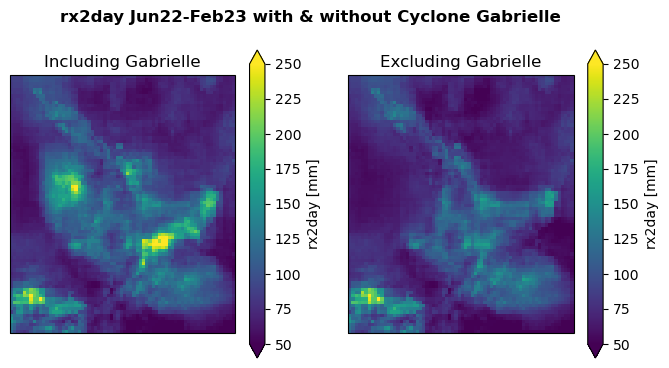

In [48]:
incl = xr.open_dataset("data/mswep_rx2day.nc").rx2day
excl = xr.open_dataset("data/mswep_rx2day_excluding-event.nc").rx2day

fig, axs = plt.subplots(ncols = 2, figsize = (8,4), dpi = 100, sharey = False, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

incl.sel(time = 2023).plot(ax = axs[0], vmin = 50, vmax = 250)
axs[0].set_title("Including Gabrielle")
excl.sel(time = 2023).plot(ax = axs[1], vmin = 50, vmax = 250)
axs[1].set_title("Excluding Gabrielle")

plt.suptitle("rx2day Jun22-Feb23 with & without Cyclone Gabrielle", fontweight = "bold")

### **Spatial pattern**

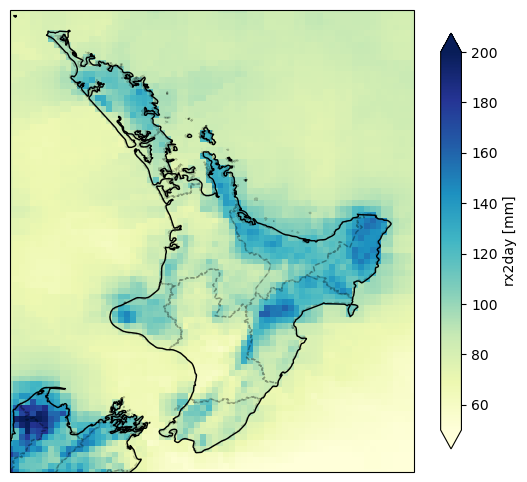

In [3]:
rx2day = xr.open_dataset("data/mswep_rx2day.nc").rx2day
regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())

cbar_kwargs = {"shrink" : 0.9}

fig, ax = plt.subplots(ncols = 1, figsize = (7,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (rx2day.lon.min().values, rx2day.lon.max().values, rx2day.lat.min().values, rx2day.lat.max().values)})

rx2day.mean("time").plot(ax = ax, cmap = "YlGnBu", vmin = 50, vmax = 200, cbar_kwargs = cbar_kwargs)

ax.coastlines(color = "k")
regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.2)

plt.savefig("mswep-spatial-pattern.png")

### **Check cutpoint for water year**

Text(0.5, 1.0, '')

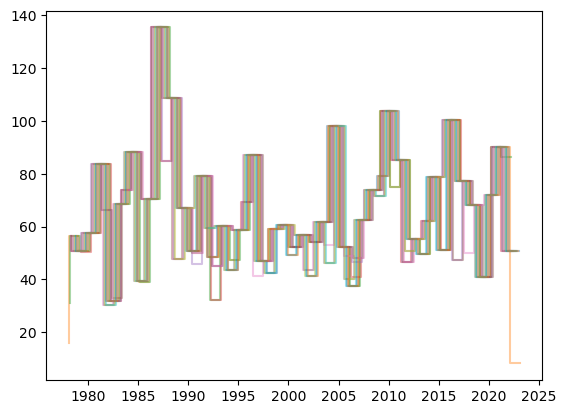

In [42]:
# exact timing of water year makes very little difference
pr_2day = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation.rolling(time = 2, center = False).sum()
hg = pr.where(regionmask.mask_3D_geopandas(gpd.read_file("sf_hawkes-gisborne/"), pr.lon, pr.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).load()

zz = [hg.resample(time = "AS-"+datetime(2022,m+1,1).strftime("%b").upper()).max() for m in range(12)]

[plt.step(da.time, da, alpha = 0.4) for da in zz]
plt.title("")

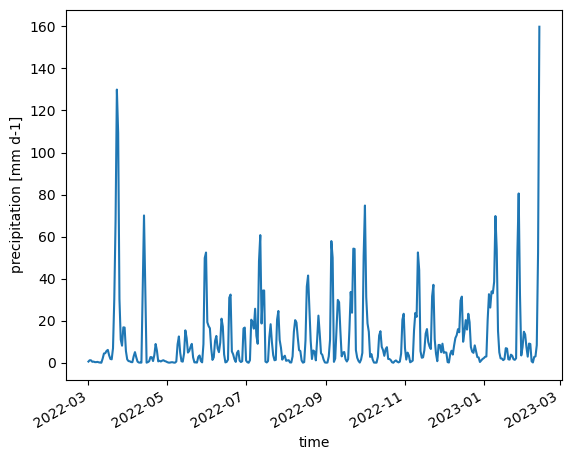

In [161]:
# most extreme event is still this one, even if we include the entire preceding year
hg.sel(time = slice("2022-03", None)).plot()

### **Time series for climate explorer**

In [270]:
# work with MSWEP daily precip (UTC so some care needed when talking about event times)
pr = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation

hg = gpd.read_file("sf_hawkes-gisborne/")
hgp = gpd.read_file("sf_hawkes-gisborne-plenty/")
ne = gpd.read_file("sf_ne-coast")
na = gpd.read_file("sf_northland-auckland")

for region in ["hg", "hgp", "ne", "na"]:
        
    csv_fnm = "ts/NZ-flood_rx2day_mswep_"+region+".dat"
    
    rnm = {"hg" : "Hawkes Bay & Gisborne", "hgp" : "Hawkes Bay, Gisborne & Bay of Plenty", "ne" : "Northeastern coastal region", "na" : "Northland & Auckland"}
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: MSWEP rx2day ("+rnm[region]+") New Zealand flooding 2023, c.barnes22@imperial.ac.uk"
    str2 = "# rx2day [mm] 2-day accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year rx2day"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get average precip over region of interest, accumulate over two days, get annual maximum
    pr_daily = pr.where(regionmask.mask_3D_geopandas(eval(region), pr.lon, pr.lat).squeeze(drop = True) == 1).mean(["lat", "lon"])
    rx2day = pr_daily.rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().dropna("time", "any")
    rx2day = rx2day.assign_coords(time = rx2day.time.dt.year + 1)

    rx2day.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    

### **Fitted model per grid cell**

Model fitting is quite slow, so try to avoid re-fitting

In [44]:
# # fit fixed-dispersion GEV to each grid cell
# mswep = xr.open_dataset("data/mswep_rx2day.nc").rx2day
# gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year").to_xarray().sel(year = mswep.time).gmst

# mfit = ns_mapfit(gev, "fixeddisp", mswep, gmst)
# mfit.to_netcdf("mswep_rx2day_fitted-gev-fixeddisp.nc")

In [54]:
# # also fit without Cyclone Gabrielle, in case of high leverage
# mswep_excl = xr.open_dataset("data/mswep_rx2day_excluding-event.nc").rx2day
# gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year").to_xarray().sel(year = mswep.time).gmst

# mfit_excl = ns_mapfit(gev, "fixeddisp", mswep_excl, gmst)
# mfit_excl.to_netcdf("mswep_rx2day_fitted-gev-fixeddisp_excluding-event2.nc")

#### **Check fitted model**

Text(0.5, 0.98, 'Fitted parameters including Cyclone Gabrielle')

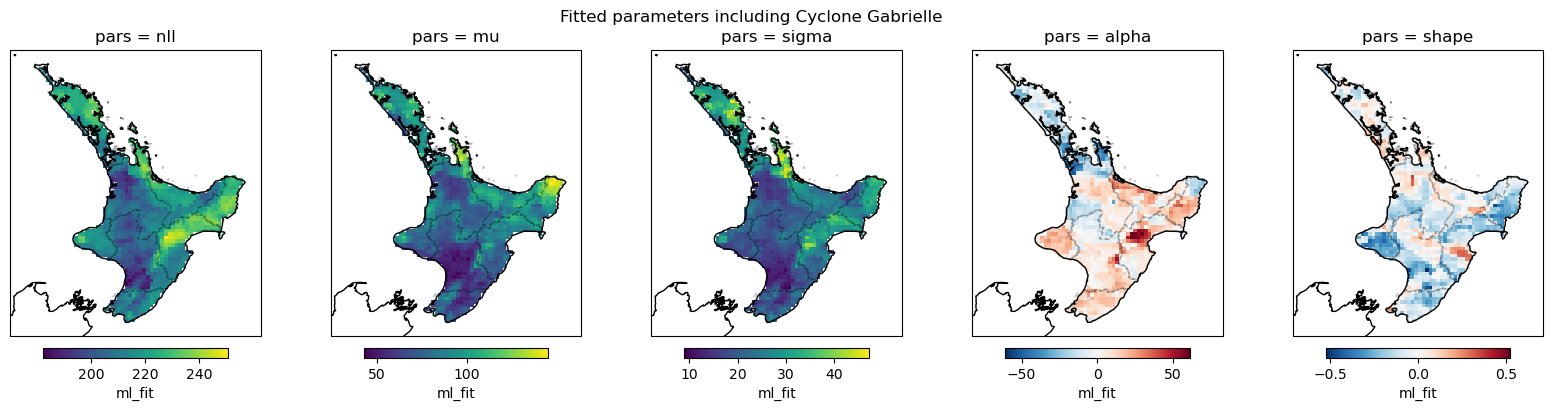

In [57]:
fitted = xr.open_dataset("mswep_rx2day_fitted-gev-fixeddisp.nc")
gmst = fitted.covariate

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())[:9]
lsm = regionmask.mask_3D_geopandas(regions, fitted.lon, fitted.lat).sum("region")
mfit = fitted.ml_fit.assign_attrs(units = "").where(lsm == 1)

fig, axs = plt.subplots(ncols = 5, figsize = (20,4), dpi = 100, sharey = False, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

for i in range(5):
    mfit.isel(pars = i+1).plot(ax = axs[i], cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04})
    axs[i].coastlines(color = "k")
    regions.boundary.plot(ax = axs[i], color = "k", lw = 1, ls = "--", alpha = 0.2)
    
plt.suptitle("Fitted parameters including Cyclone Gabrielle")
# huge trend in Hawkes Bay region (Esk Valley?). Confirm against stations.

Text(0.5, 0.98, 'Fitted parameters excluding Cyclone Gabrielle')

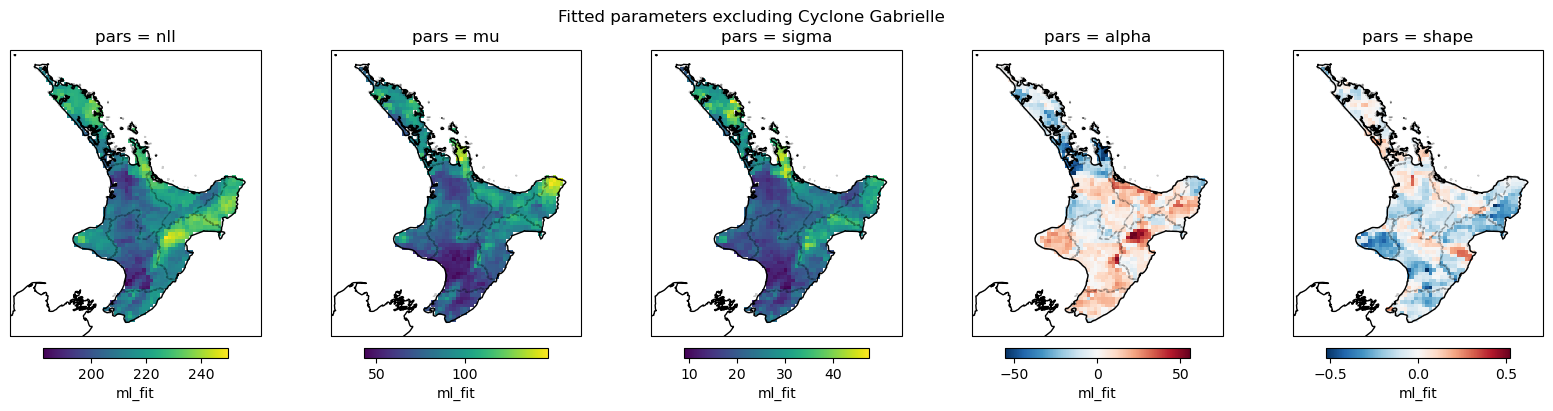

In [58]:
fitted_excl = xr.open_dataset("mswep_rx2day_fitted-gev-fixeddisp_excluding-event.nc")
gmst = fitted_excl.covariate

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())[:9]
lsm = regionmask.mask_3D_geopandas(regions, fitted_excl.lon, fitted_excl.lat).sum("region")
mfit_excl = fitted_excl.ml_fit.assign_attrs(units = "").where(lsm == 1)

fig, axs = plt.subplots(ncols = 5, figsize = (20,4), dpi = 100, sharey = False, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

for i in range(5):
    mfit_excl.isel(pars = i+1).plot(ax = axs[i], cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04})
    axs[i].coastlines(color = "k")
    regions.boundary.plot(ax = axs[i], color = "k", lw = 1, ls = "--", alpha = 0.2)
    
# trend remains, suggesting not due to high leverage from Cyclone Gabrielle
plt.suptitle("Fitted parameters excluding Cyclone Gabrielle")

Text(0.5, 0.98, 'Change in fitted parameters when Cyclone Gabrielle is included')

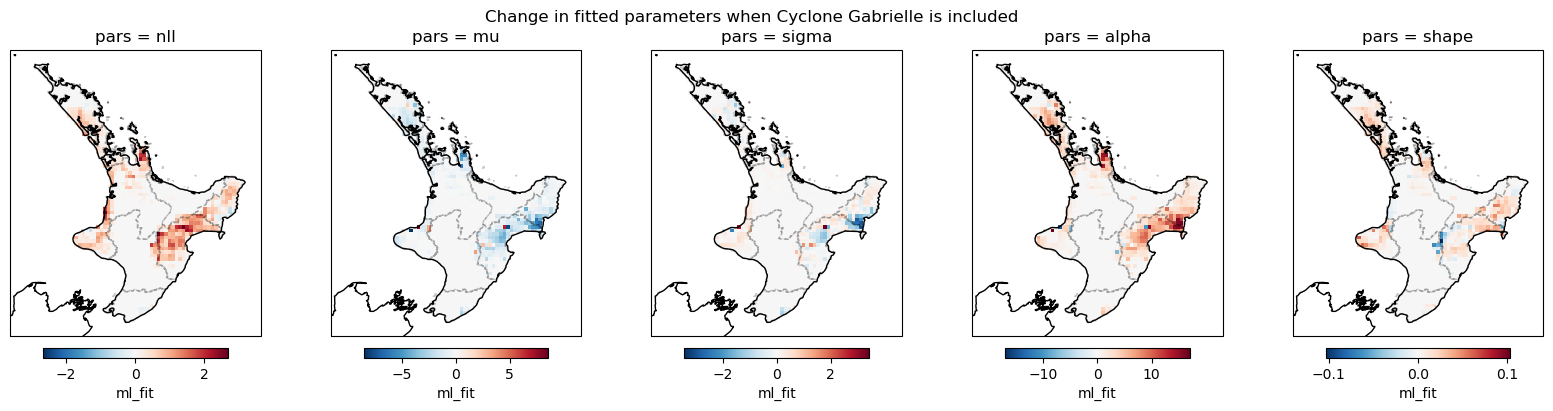

In [59]:
fit_diff = mfit - mfit_excl

fig, axs = plt.subplots(ncols = 5, figsize = (20,4), dpi = 100, sharey = False, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

for i in range(5):
    fit_diff.isel(pars = i+1).plot(ax = axs[i], cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04})
    axs[i].coastlines(color = "k")
    regions.boundary.plot(ax = axs[i], color = "k", lw = 1, ls = "--", alpha = 0.2)
    
# trend remains, suggesting not due to high leverage from Cyclone Gabrielle
plt.suptitle("Change in fitted parameters when Cyclone Gabrielle is included")

#### **Estimated return period of event**

In [29]:
event_value = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())[:9]
lsm = regionmask.mask_3D_geopandas(regions, event_value.lon, event_value.lat).sum("region")

mfit_with_event = xr.open_dataset("mswep_rx2day_fitted-gev-fixeddisp.nc")
gmst = mfit_with_event.covariate
mfit_with_event = mfit_with_event.ml_fit.where(lsm == 1)

mfit_excl_event = xr.open_dataset("mswep_rx2day_fitted-gev-fixeddisp_excluding-event.nc").ml_fit.where(lsm == 1)

hg = gpd.read_file("sf_hawkes-gisborne")

In [24]:
event_rp = rpmap(mfit_with_event, event_value, gmst.sel(time = 2023))
event_rp_past = rpmap(mfit_with_event, event_value, gmst.sel(time = slice(None, 1990)).mean())

event_rp_excl = rpmap(mfit_excl_event, event_value, gmst.sel(time = 2023)).where(lsm == 1)

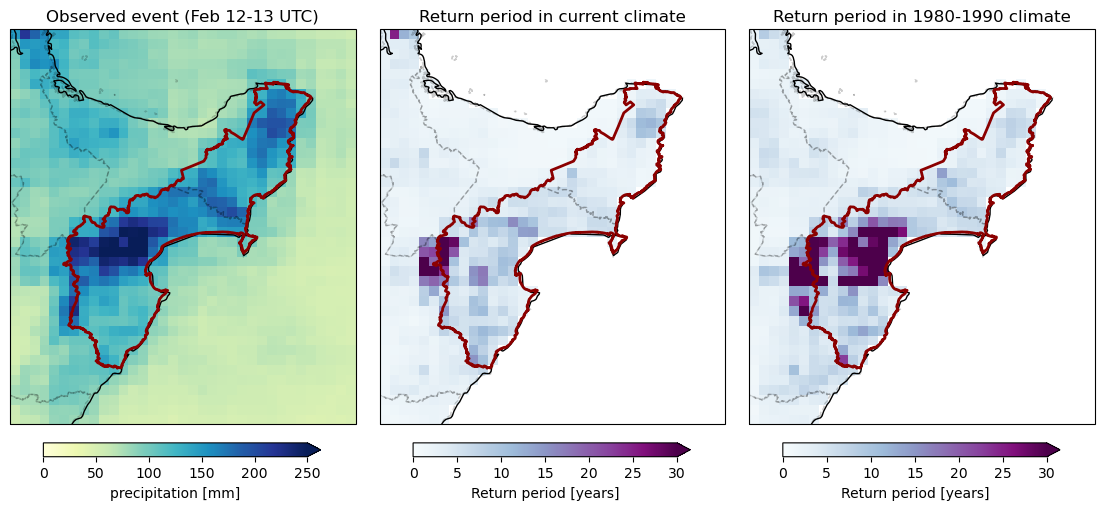

In [34]:
fig, axs = plt.subplots(ncols = 3, figsize = (14,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (175.5,179,-37,-41)})
plt.subplots_adjust(wspace = 0.07)
cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04}

event_value.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, vmax = 250, cbar_kwargs = cbar_kwargs); axs[0].set_title("Observed event (Feb 12-13 UTC)")
event_rp.plot(ax = axs[1], cmap = "BuPu", cbar_kwargs = cbar_kwargs, vmin = 0, vmax = 30); axs[1].set_title("Return period in current climate")
event_rp_past.plot(ax = axs[2], cmap = "BuPu", cbar_kwargs = cbar_kwargs, vmin = 0, vmax = 30); axs[2].set_title("Return period in 1980-1990 climate")
# event_rp_excl.plot(ax = axs[2], cmap = "Purples", cbar_kwargs = cbar_kwargs, vmin = 0, vmax = 30); axs[2].set_title("Return period excluding event")

for ax in axs:
    ax.coastlines(color = "k")
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.2)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred")
    
plt.savefig("mswep_rx2day_change-in-return-period.png")

### **Trends in each candidate region**

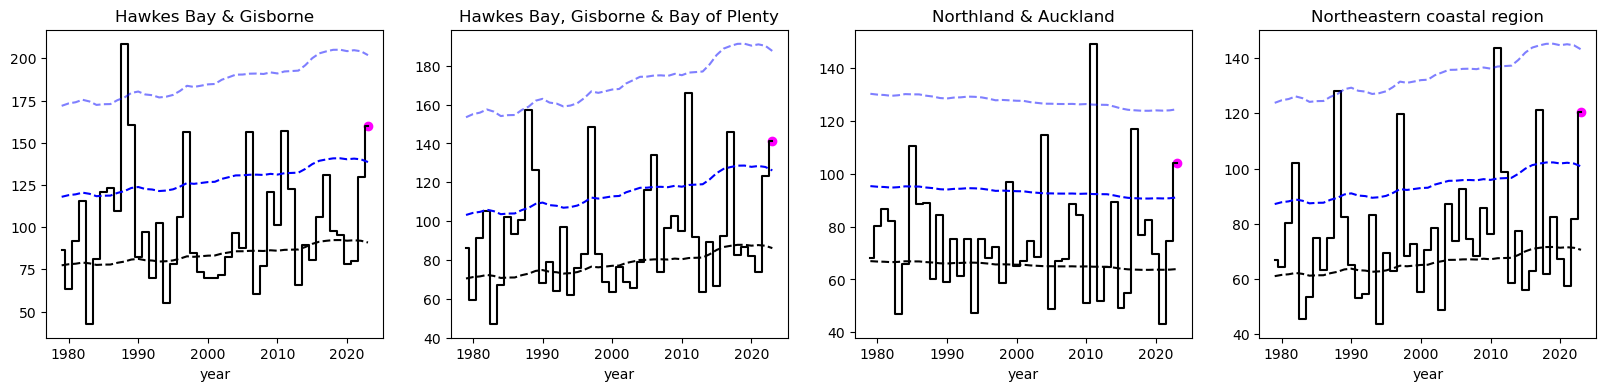

In [82]:
regions = {"hg" : "Hawkes Bay & Gisborne", "hgp" : "Hawkes Bay, Gisborne & Bay of Plenty", "na" : "Northland & Auckland", "ne" : "Northeastern coastal region"}

fig, axs = plt.subplots(ncols = 4, figsize = (20,4), dpi = 100, sharey = False)

for region in list(regions.keys()):
    
    df = pd.merge(pd.read_csv("ts/NZ-flood_rx2day_mswep_"+region+".dat", comment = "#", sep = " ", header = None, names = ["year", "rx2day"]), 
                  pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"])).set_index("year")
    
    event_gmst = df.loc[2023,"gmst"]
    event_value = df.loc[2023,"rx2day"]
    
    mdl = ns_fit(gev, "fixeddisp", df, "gmst", "rx2day")
    
    i = list(regions.keys()).index(region)
    
    ax = axs[i]
    ax.step(df.index, df.rx2day, color = "k", where = "mid")
    ns_pars(mdl)["loc"].plot(ax = ax, color = "k", ls = "--")
    ax.plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
    ax.plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
    ax.scatter(2023, df.loc[2023, "rx2day"],color = "magenta")
    
    ax.set_title(regions[region])


### **Trend in Hawkes Bay/Gisborne regions**

In [279]:
df = pd.merge(pd.read_csv("ts/NZ-flood_rx2day_mswep_hg.dat", comment = "#", sep = " ", header = None, names = ["year", "rx2day"]), 
              pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"])).set_index("year")

event_gmst = df.loc[2023,"gmst"]
event_value = df.loc[2023,"rx2day"]

mdl = ns_fit(gev, "fixeddisp", df, "gmst", "rx2day")

event_rp = return_period(mdl, event_value, event_gmst)
past_rp = return_period(mdl, event_value, event_gmst-1.2)

dI = delta_I(mdl, event_rp, event_gmst, event_gmst - 1.2, relative = True)
pr = prob_ratio(mdl, event_value, event_gmst, event_gmst - 1.2)

print()
print("Return period in current climate:", int(event_rp))
print("Return period in past climate:", int(past_rp))
print()
print("Probability ratio:", pr.round(2))
print("Change in intensity:", dI.round(2),"%")
print()

# # bootstrap parameters
# boot_res = boot_results(mdl, event_gmst, event_gmst-1.2, event_value = event_value, rp = 11, relative_deltaI = True)
# boot_res.to_csv("tmp_boot-results.csv")


Return period in current climate: 11
Return period in past climate: 50

Probability ratio: 4.43
Change in intensity: 31.63 %



/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


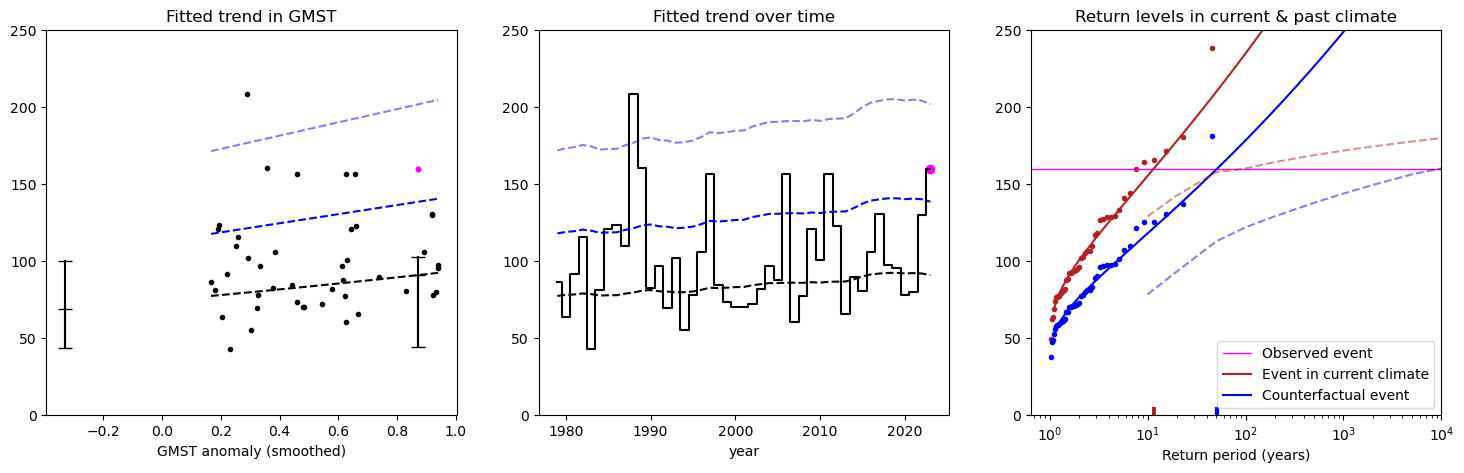

In [280]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), dpi = 100, sharey = False)

boot_res = pd.read_csv("tmp_boot-results.csv")
trendplot(mdl, event_gmst, event_gmst-1.2, ax = axs[0], loc1 = boot_res.loc1, loc2 = boot_res.loc2)

axs[1].step(df.index, df.rx2day, color = "k", where = "mid")
ns_pars(mdl)["loc"].plot(ax = axs[1], color = "k", ls = "--")
axs[1].plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
axs[1].plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
axs[1].scatter(2023, df.loc[2023, "rx2day"],color = "magenta")

rlplot(mdl, event_gmst, event_gmst-1.2, event_value, ax = axs[2], ci_nsamp = 100)

for ax in axs: ax.set_ylim(0, 250)

axs[0].set_title("Fitted trend in GMST")
axs[1].set_title("Fitted trend over time")
axs[2].set_title("Return levels in current & past climate")

plt.savefig("mswep_rx2day_trendplots_hawkes-gisborne.png")

---
## **NIWA station data**


### **Selection of sites**

In [367]:
# load all station data, order by latitude
stn_data = pd.concat([pd.read_csv(fnm, skiprows = 1, nrows = 1, index_col = "Agent Number") for fnm in glob.glob("stations/stn_*.txt")]).rename(columns = {"Latitude (dec.deg)" : "lat", "Longitude (dec.deg)" : "lon"})
stn_data = stn_data.sort_values("lat", ascending = False)

# clip points to shapefile
stn_in_region = gpd.sjoin(gpd.GeoDataFrame(stn_data, geometry = gpd.points_from_xy(stn_data.lon, stn_data.lat)),
                          gpd.read_file("sf_hawkes-gisborne"), predicate = "within").index.to_list()
stn_data = stn_data.loc[stn_in_region]

stn_data.to_csv("stations/stationdata.csv")

In [381]:
# load observations, remove any not in study region
obs = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
            [pd.read_csv(fnm, skiprows = 8, index_col = "Date(NZST)", parse_dates = True)[["Amount(mm)"]].rename(columns = {"Amount(mm)" : fnm[13:-4]}) for fnm in glob.glob("stations/stn_*.txt")])
obs = obs[[str(s) for s in stn_data.index]].dropna(axis = 1, how = "all")

# identify stations that actually recorded the event
include = list(obs.loc[["2023-02-14"]].dropna(axis = 1, how = "any").columns)

# identify stations with obs as far back as 1980
long_ts = list(obs.loc[slice(None, "1980")].dropna(axis = 1, how = "all").columns)

Text(0, 0.5, 'Station ID')

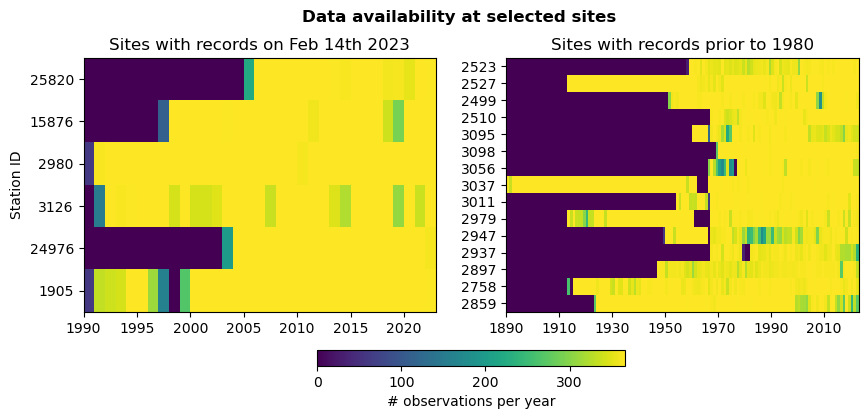

In [388]:
# check intactness of data

fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100)

n_obs_incl = obs.loc[slice(None, "2022"), include].dropna(axis = 0, how = "all").resample("AS-JAN").count()
n_obs_longts = obs.loc[slice(None, "2022"), long_ts].dropna(axis = 0, how = "all").resample("AS-JAN").count()

for i in range(2):
    
    stn_list = [include, long_ts][i]
    n_obs = obs.loc[slice(None, "2022"), stn_list].dropna(axis = 0, how = "all").resample("AS-JAN").count()
    
    ax = axs[i]
    cbar = ax.pcolormesh(n_obs.transpose())
    xticks = [x for x in ax.get_xticks() if x < len(n_obs)]
    
    ax.set_xticks(xticks)
    ax.set_xticklabels([n_obs.index.year[int(i)] for i in xticks])
    ax.set_yticks(ticks = [y + 0.5 for y in range(len(stn_list))])
    ax.set_yticklabels(stn_list)
    ax.set_title(["Sites with records on Feb 14th 2023", "Sites with records prior to 1980"][i])
    
    plt.suptitle("Data availability at selected sites", y = 1, fontweight = "bold")
    
plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.9, fraction = 0.05, pad = 0.125, label = "# observations per year")
axs[0].set_ylabel("Station ID")
    
# sites that actually recorded the event have very short time series
# some missingness throughout, probably not at random

### **Map of selected stations**

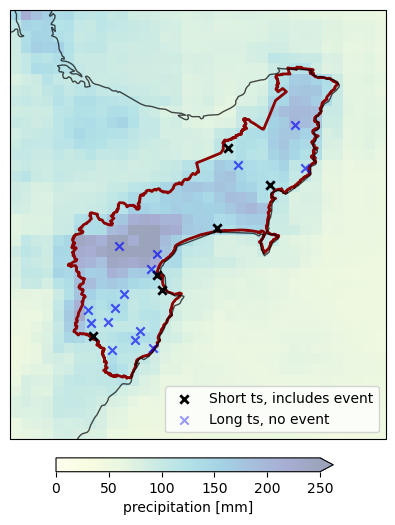

In [507]:
hg = gpd.read_file("sf_hawkes-gisborne")
event_value = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")

cbar_kwargs = {"shrink" : 0.9}
fig, ax = plt.subplots(ncols = 1, figsize = (6,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (175.5,179,-37,-41)})

event_value.plot(ax = ax, cmap = "YlGnBu", alpha = 0.4, vmin = 0, vmax = 250, cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04}, zorder = -2)

ax.coastlines(color = "k", alpha = 0.7)
hg.boundary.plot(ax = ax, lw = 2, color = "darkred", zorder = -1)

stn_incl = stn_data.loc[[int(s) for s in include]]
stn_val = stn_data.loc[[int(s) for s in long_ts]]

ax.scatter(stn_data.lon, stn_data.lat, marker = "x", color = "blue", alpha = 0.4)

ax.scatter(stn_incl.lon, stn_incl.lat, marker = "x", color = "k", lw = 2, label = "Short ts, includes event")
ax.scatter(stn_val.lon, stn_val.lat, marker = "x", color = "blue", alpha = 0.4, label = "Long ts, no event")

# [ax.annotate(k, xy = [v.lon, v.lat], textcoords="offset points", xytext=(0,5), ha = 'left', fontweight = "bold", color = "blue") for k,v in stn_data.iterrows()]
# [ax.annotate(k, xy = [v.lon, v.lat], textcoords="offset points", xytext=(0,5), ha = 'left', fontweight = "bold") for k,v in stn_incl.iterrows()]

ax.legend(loc = "lower right")
plt.savefig("station-locations.png")

### **Validation of MSWEP vs stations**

In [ ]:
obs = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
            [pd.read_csv(fnm, skiprows = 8, index_col = "Date(NZST)", parse_dates = True)[["Amount(mm)"]].rename(columns = {"Amount(mm)" : fnm[13:-4]}) for fnm in glob.glob("stations/stn_*.txt")])

# filter only stations within shapefile
stn_data = pd.read_csv("stations/stationdata.csv", index_col = 0)
obs = obs[[str(s) for s in stn_data.index]].dropna(axis = 1, how = "all")

include = list(obs.loc[["2023-02-14"]].dropna(axis = 1, how = "any").columns)   # stations that actually recorded the event
long_ts = list(obs.loc[slice(None, "1978")].dropna(axis = 1, how = "all").columns)   # stations with obs as far back as 1980

# filter to selected stations
obs = obs[include + long_ts]
stn_data = stn_data.loc[[int(s) for s in obs.columns]]

In [521]:
# get rx2day at each station (only interested in years from summer 1978-9 onwards)
rx2day_obs = obs.rolling(2).sum().resample("AS-JUL", label = "right").max()
rx2day_obs = rx2day_obs.set_index(rx2day_obs.index.year).loc[slice("1979", None)]

In [447]:
# method to get closest point from MSWEP
def nearest_px(lon,lat,da):
    dist2 = (da.lon - lon)**2 + (da.lat - lat)**2   # get squared distance from (lon, lat) to each point
    dist2 = dist2.where(~np.isnan(da))   # exclude any cells where the gridded data is NaN
    return da.where(dist2 == dist2.min()).mean(["lat", "lon"])

# load gridded data, extract time series at grid cell closest to station
mswep = xr.open_dataset("data/mswep_rx2day.nc").rx2day
mswep_stn = xr.concat([nearest_px(v.lon, v.lat, mswep).expand_dims(stn = [k]) for k,v in stn_data.iterrows()], "stn")

In [530]:
# count number of DJF days available each year
n_obs = obs.loc[[m in [12,1,2,3,4,5] for m in obs.index.month]].resample("AS-JUL", label = "right").count()
n_obs.iloc[-1] = 182
n_obs = n_obs.set_index(n_obs.index.year).loc[slice("1979", None)]

# filter time series - only include where most of DJFMAM was observed (can change this, but think this was wettest period?)
rx2day_obs = rx2day_obs.where(n_obs >= 165)

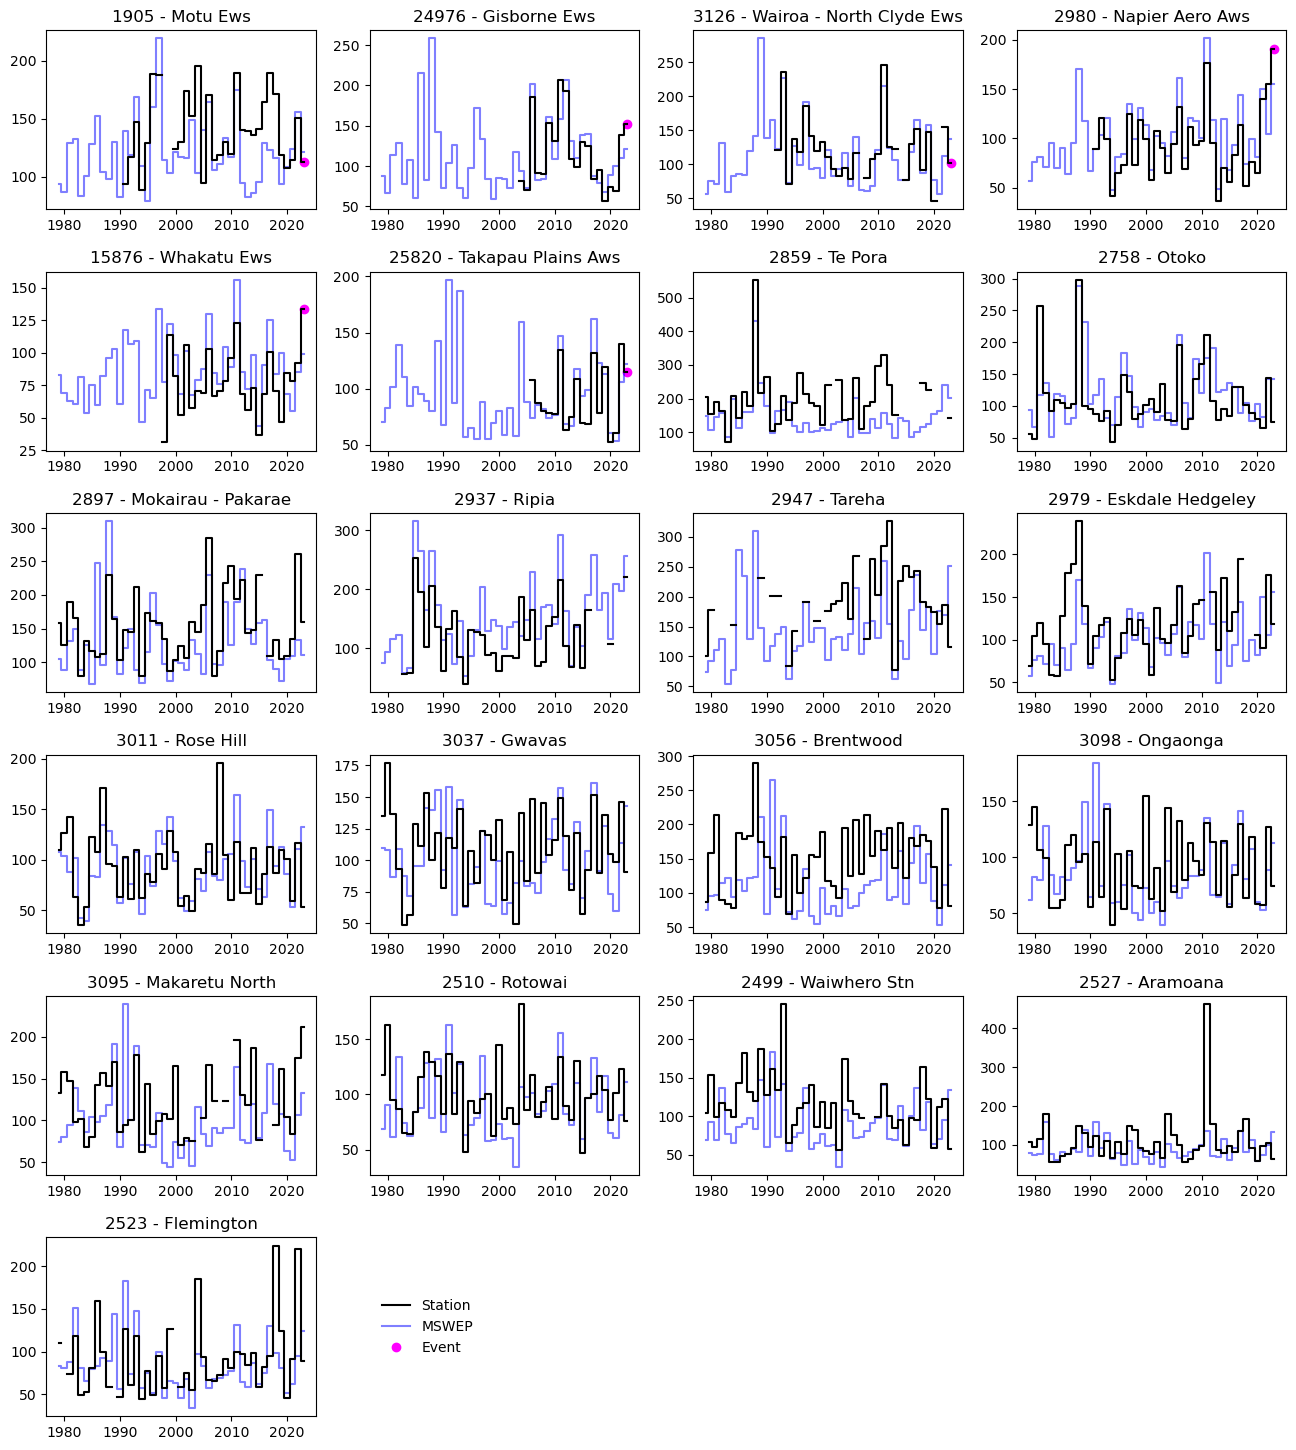

In [531]:
# plot of station data vs MSWEP grid cell data
nc = 4
nr = int(np.ceil(len(stn_data) / nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr * 3), dpi = 100, sharey = False)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(rx2day_obs.columns)):
    
    ax = plt.gcf().axes[i]
    stn = rx2day_obs.columns[i]
            
    ax.step(mswep_stn.time, mswep_stn.sel(stn = int(stn)), color = "blue", alpha = 0.5, where = "mid")
    ax.step(rx2day_obs.index, rx2day_obs[stn], color = "k", where = "mid")
    ax.set_title(stn+" - "+stn_data.loc[int(stn)].Name)
    if stn in include:
        event_value = rx2day_obs.loc[2023,stn]
        ax.scatter(2023, rx2day_obs.loc[2023, stn], color = "magenta", label = "Event")
    
for i in range(len(rx2day_obs.columns), nc*nr): plt.gcf().axes[i].set_axis_off()

plt.gcf().axes[len(rx2day_obs.columns)].legend(handles = [matplotlib.lines.Line2D([], [], color = "k", label = "Station"),
                                                          matplotlib.lines.Line2D([], [], color = "blue", alpha = 0.5, label = "MSWEP"),
                                                          matplotlib.lines.Line2D([], [], color = "magenta", marker = "o", ls = "", label = "Event")],
                                               loc = "center left", edgecolor = "w")
    
plt.savefig("mswep-station-validation.png")